## Image Focus and Astigmatism Classifier
**Author:** [Aaron Woods](https://aaronwoods.info)  
**Date Created:** September 12, 2023  
**Description:** This script provides an end-to-end machine learning pipeline to classify images as either "In Focus" or "Out of Focus", and additionally identifies astigmatism-related issues.  
**Repository:** [Image Classification on VSCode](https://insiders.vscode.dev/tunnel/midnightsim/c:/Users/User/Desktop/Image-Classification)

### Overview
The script features a comprehensive pipeline that ingests data from Excel spreadsheets and feeds it into various machine learning models. The design is modular, allowing for easy adaptability to address different image classification problems, including focus quality and astigmatism detection.


## Setup

In [106]:
# ------------------------------
# TensorFlow Installation with GPU Support
# ------------------------------
# Note: TensorFlow versions above 2.10 are not supported on GPUs on native Windows installations.
# For more details, visit: https://www.tensorflow.org/install/pip#windows-wsl2_1
# Uncomment the following line to install TensorFlow if needed.
# %pip install "tensorflow<2.11"

# ------------------------------
# System and TensorFlow Info Check
# ------------------------------
# Import necessary libraries and initialize an empty dictionary to store system information.
import platform
system_info = {"Platform": platform.platform(), "Python Version": platform.python_version()}

# Try importing TensorFlow and collecting relevant system information.
try:
    import tensorflow as tf
    system_info.update({
        "TensorFlow Version": tf.__version__,
        "Num GPUs Available": len(tf.config.list_physical_devices('GPU'))
    })
    system_info['Instructions'] = (
        "You're all set to run your model on a GPU." 
        if system_info['Num GPUs Available'] 
        else (
            "No GPUs found. To use a GPU, follow these steps:\n"
            "  1. Install NVIDIA drivers for your GPU.\n"
            "  2. Install a compatible CUDA toolkit.\n"
            "  3. Install the cuDNN library.\n"
            "  4. Make sure to install the GPU version of TensorFlow."
        )
    )
except ModuleNotFoundError:
    system_info['Instructions'] = (
        "TensorFlow is not installed. "
        "Install it using pip by running: !pip install tensorflow"
    )

# Format and display the gathered system information.
formatted_info = "\n".join(f"{key}: {value}" for key, value in system_info.items())
print(formatted_info)

Platform: Windows-10-10.0.22621-SP0
Python Version: 3.10.9
TensorFlow Version: 2.13.0
Num GPUs Available: 0
Instructions: No GPUs found. To use a GPU, follow these steps:
  1. Install NVIDIA drivers for your GPU.
  2. Install a compatible CUDA toolkit.
  3. Install the cuDNN library.
  4. Make sure to install the GPU version of TensorFlow.


In [107]:
# ------------------------------
# Package Installation (Optional)
# ------------------------------
# Uncomment the following lines to install required packages if running on a new machine.
# To suppress the output, we use '> /dev/null 2>&1'.
# %pip install numpy pandas matplotlib protobuf seaborn scikit-learn tensorflow > /dev/null 2>&1

# ------------------------------
# Import Libraries
# ------------------------------

# Standard Libraries
import os, sys, random, math, glob, logging
from datetime import datetime
from collections import defaultdict

# Third-Party Libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from IPython.display import clear_output
from collections import Counter
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import TensorBoard, Callback
from tensorflow.keras.applications import InceptionV3, ResNet50
from keras.models import load_model
from tensorflow.data import Dataset

import pickle

# Type Annotations
from typing import List, Dict, Tuple, Union, Any, Optional


## Configuration

In [108]:
# Configuration dictionary
config = {
    'Experiment': {
        'NAME': "Version8",  # Experiment name
        'RANDOM_SEED': 42,  # Seed for reproducibility
        'PROBLEM_TYPE': 'Multi-Class',  # Problem type: Binary, Multi-Class, Multi-Output, Multi-Label
    },
    'Model': {
        'IMG_SIZE': 224,  # Image input size
        'BATCH_SIZE': 32,  # Batch size for training
        'TRAIN_SIZE': 0.8,  # Fraction of data to use for training
        'VAL_SIZE': 0.5,  # Fraction of data to use for validation
    },
    'Labels': {
        'MAPPINGS': {  # Class label mappings
            'Focus_Label': {'SharpFocus': 0, 'SlightlyBlurred': 1, 'HighlyBlurred': 2},
            'StigX_Label': {'OptimalStig_X': 0, 'ModerateStig_X': 1, 'SevereStig_X': 2},
            'StigY_Label': {'OptimalStig_Y': 0, 'ModerateStig_Y': 1, 'SevereStig_Y': 2},
        }
    },
    'Augmentation': {  # Data augmentation parameters
        'rotation_factor': 0.002,
        'height_factor': (-0.18, 0.18),
        'width_factor': (-0.18, 0.18),
        'contrast_factor': 0.5,
    }
}


In [109]:
# Set random seed for reproducibility
np.random.seed(config['Experiment']['RANDOM_SEED'])
tf.random.set_seed(config['Experiment']['RANDOM_SEED'])

### Recommendations for Loss Functions and Other Settings Per Problem Type

#### Multi-Label Problems:
- **Loss Function**: Typically, "binary_crossentropy" is used because each class label is independent and the task is to predict whether it is present or not.
- **Label Encoding**: One-hot encoding is commonly used where each label is considered as a separate class.
- **Activation Function**: The sigmoid activation function is generally used in the output layer to allow for multiple independent classes.
- **Evaluation Metrics**: Precision, Recall, and F1 Score can be effective for evaluating multi-label problems.

#### Binary Classification Problems:
- **Loss Function**: "binary_crossentropy" is the standard loss function because the task is to categorize instances into one of the two classes.
- **Label Encoding**: Labels are often encoded as 0 or 1.
- **Activation Function**: The sigmoid activation function is usually used in the output layer, producing a probability score that can be thresholded to yield a class label.
- **Evaluation Metrics**: Accuracy, Precision, Recall, and AUC-ROC are commonly used metrics.

#### Multi-Class Problems:
- **Loss Function**: "categorical_crossentropy" or "sparse_categorical_crossentropy" is commonly used. The former requires one-hot encoded labels, while the latter requires integer labels.
- **Label Encoding**: One-hot encoding is often used to convert the categorical labels into a format that can be provided to the neural network.
- **Activation Function**: The softmax activation function is used in the output layer to produce a probability distribution over the multiple classes.
- **Evaluation Metrics**: Accuracy is the most straightforward metric. However, Precision, Recall, and F1 Score can also be used for imbalanced datasets.

Remember to refer to these guidelines when setting up your configuration for different types of problems.


## Load and Preprocess the data

### Functions for Preparation of CSV

In [110]:
# Read the data

def read_csv(config: Dict):
    # Functionality to read the data
    data_file_path = os.path.join(config['Paths']['NEW_BASE_PATH'], config['Paths']['DATA_FILE'])
    if not os.path.exists(data_file_path):
        raise FileNotFoundError(f"Error: File does not exist - {data_file_path}")
    try:
        data = pd.read_csv(data_file_path, usecols=config['CSV']['COLUMNS_TO_READ'])
        print("---> Data read successfully.")
        sample_frac = config.get('SAMPLE_FRAC', 1.0)
        if 0 < sample_frac < 1.0:
            data = data.sample(frac=sample_frac).reset_index(drop=True)
            print(f"---> Data sampled: Using {sample_frac * 100}% of the available data.")
    except Exception as e:
        raise ValueError(f"Error: Could not read data - {e}") from e
    return data

def update_image_paths(df):
    old_base_path = config['Paths']['OLD_BASE_PATH']
    new_base_path = config['Paths']['NEW_BASE_PATH']
    df['ImageFile'] = df['ImageFile'].str.replace(old_base_path, new_base_path, regex=False)
    print("---> Image paths updated.")
    return df

def clean_csv(df: pd.DataFrame) -> pd.DataFrame:
    def is_valid_string(image_path) -> bool:
        return isinstance(image_path, str)
    def does_file_exist(image_path) -> bool:
        return os.path.exists(image_path)
    def can_image_be_read(image_path) -> bool:
        img = cv2.imread(image_path)
        return img is not None
    invalid_rows = []
    removal_reasons = defaultdict(int)  # Dictionary to count reasons for removal
    for index, row in df.iterrows():
        image_path = row['ImageFile']
        reason = None  # Initialize removal reason as None
        if not is_valid_string(image_path):
            reason = "Invalid ImageFile value - not a string"
        elif not does_file_exist(image_path):
            reason = "File does not exist"
        elif not can_image_be_read(image_path):
            reason = "Image can't be read"
        if reason:
            removal_reasons[reason] += 1  # Count the reason for removal
            invalid_rows.append(index)
    # Drop invalid rows
    df.drop(index=invalid_rows, inplace=True)
    df.reset_index(drop=True, inplace=True)
    # Print summary of removal reasons
    print("Summary of row removals:")
    for reason, count in removal_reasons.items():
        print(f"{count} rows removed due to: {reason}")
    return df


### Generating labels

In [111]:
# Generating labels
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
import numpy as np
import pandas as pd
from typing import Dict

def generate_thresholds(label_key):
    low_key = f"{label_key.split('_')[0].upper()}_LOW"
    high_key = f"{label_key.split('_')[0].upper()}_HIGH"
    return config.get('Thresholds', {}).get(low_key, 0), config.get('Thresholds', {}).get(high_key, 0)

def generate_single_label(df_copy, label_key, offset_column, choices_dict):
    low_threshold, high_threshold = generate_thresholds(label_key)
    conditions = [
        (df_copy[offset_column].abs() <= low_threshold),
        (df_copy[offset_column].abs() > low_threshold) & (df_copy[offset_column].abs() <= high_threshold),
        (df_copy[offset_column].abs() > high_threshold)
    ]
    choices = list(choices_dict.keys())
    df_copy[label_key] = np.select(conditions, choices, default='Unknown')
    le = LabelEncoder()
    df_copy[label_key] = le.fit_transform(df_copy[label_key])
    return le

def generate_labels(df: pd.DataFrame):
    print("---> Generating labels for Focus, StigX, and StigY...")
    labels_config = config.get('Labels', {}).get('MAPPINGS', {})
    offset_column_mapping = {'Focus_Label': 'Focus_Offset (V)', 'StigX_Label': 'Stig_Offset_X (V)', 'StigY_Label': 'Stig_Offset_Y (V)'}

    df_copy = df.copy()
    label_encoders = {}

    for label_key, choices_dict in labels_config.items():
        offset_column = offset_column_mapping.get(label_key)
        if not offset_column:
            print(f"Warning: No offset column mapping found for '{label_key}'. Skipping label generation.")
            continue
        if offset_column not in df.columns:
            print(f"Warning: Column '{offset_column}' not found in DataFrame. Skipping label generation for '{label_key}'.")
            continue
        label_encoders[label_key] = generate_single_label(df_copy, label_key, offset_column, choices_dict)
        print(f"---> Labels generated for {label_key}")

    if config.get('Experiment', {}).get('PROBLEM_TYPE') == 'Multi-Output':
        df_copy['Multi_Output_Labels'] = df_copy.apply(lambda row: [row[key] for key in labels_config.keys()], axis=1)
        print("---> Multi-Output Labels generated.")
        
    return df_copy, label_encoders


### Shuffling and Splitting the Data

In [112]:
# Shuffling and Splitting the data

def shuffle_and_reset_index(data):
    print("---> Shuffling and resetting index...")
    shuffled_df = data.sample(frac=1, random_state=config['Experiment']['RANDOM_SEED']).reset_index(drop=True)
    print("---> Data shuffled and index reset.")
    return shuffled_df

def prepare_datasets(df: pd.DataFrame):
    """Prepare training, validation, and test datasets."""
    # Check if DataFrame is empty
    if df is None or df.empty:
        print("Warning: DataFrame is empty. Cannot proceed with data preparation.")
        return {'train': None, 'valid': None, 'test': None}
    # Split Data
    try:
        train_df, temp_df = train_test_split(df, test_size=1 - config['Model']['TRAIN_SIZE'], random_state=config['Experiment']['RANDOM_SEED'])
        val_df, test_df = train_test_split(temp_df, test_size=1 - config['Model']['VAL_SIZE'], random_state=config['Experiment']['RANDOM_SEED'])
    except ValueError:
        print("Not enough data to split into training, validation, and test sets.")
        return {'train': None, 'valid': None, 'test': None}
    print("---> Data split into training, validation, and test sets.")
    return {'train': train_df, 'valid': val_df, 'test': test_df}

### Computting Class Weights

In [113]:
# Compute class weights

from collections import Counter
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd
from typing import Dict


def compute_multi_output_class_weights(split, df, label, label_encoders, all_records):
    unique_labels = df[label].unique()
    class_weights = compute_class_weight('balanced', classes=unique_labels, y=df[label])
    class_weights_dict = dict(zip(unique_labels, class_weights))
    for cls, weight in class_weights_dict.items():
        cnt = Counter(df[label])[cls]
        original_class = label_encoders[label].inverse_transform([cls])[0]
        all_records.append({'split': split, 'label': label, 'class': original_class, 'Count': cnt, 'Weight': weight})

def compute_multi_label_class_weights(split, df, label, label_encoders, all_records):
    label_data = df[label].values
    unique_labels = np.unique(label_data)
    class_weights = compute_class_weight('balanced', classes=unique_labels, y=label_data)
    class_weights_dict = dict(zip(unique_labels, class_weights))
    for cls, weight in class_weights_dict.items():
        cnt = Counter(label_data)[cls]
        original_class = label_encoders[label].inverse_transform([cls])[0]
        all_records.append({'split': split, 'label': label, 'class': original_class, 'Count': cnt, 'Weight': weight})

def compute_and_store_class_weights(datasets: Dict[str, pd.DataFrame], label_encoders: Dict[str, LabelEncoder]) -> pd.DataFrame:
    problem_type = config.get('Experiment', {}).get('PROBLEM_TYPE', 'Binary')
    all_records = []
    
    for split, df in datasets.items():
        if df is None:
            continue
        for label in config['Labels']['MAPPINGS']:
            if problem_type == 'Multi-Output':
                compute_multi_label_class_weights(split, df, label, label_encoders, all_records)
            else:
                compute_multi_output_class_weights(split, df, label, label_encoders, all_records)
                
    df_class_weights = pd.DataFrame.from_records(all_records)
    df_class_weights.set_index(['split', 'label', 'class'], inplace=True)
    return df_class_weights


### Creating Tensorflow Datasets

In [114]:
# Create TensorFlow datasets

def create_tf_datasets_from_dfs(dfs: Dict[str, pd.DataFrame], include_offset=False) -> Dict[str, Dict[str, Any]]:
    """
    Create TensorFlow datasets from DataFrames for training, validation, and testing.
    Parameters:
    - dfs: Dictionary containing DataFrames for 'train', 'val', and 'test'.
    Returns:
    - Dictionary containing TensorFlow datasets for each split.
    """
    problem_type = config.get('Experiment', {}).get('PROBLEM_TYPE')
    batch_size = config.get('Model', {}).get('BATCH_SIZE', 32)
    AUTOTUNE = tf.data.AUTOTUNE
    # Create preprocessing and augmentation layers
    preprocessing_layers = create_preprocessing_layers()
    augmentation_layers = create_augmentation_layers()
    # Initialize output dictionary
    tf_datasets = {'train': {}, 'valid': {}, 'test': {}}
    
    def load_and_preprocess_image(file_path, label, offset=None, augment=False):
        file_path_str = file_path.numpy().decode('utf-8')
        image = read_and_convert_image(file_path_str)
        image = preprocessing_layers(image)
        label = tf.cast(label, tf.int32)  # Explicitly casting to tf.int32
        offset = tf.cast(offset, tf.float32) if offset is not None else None
        if augment:
            image = augmentation_layers(image)
            image = tf.clip_by_value(image, 0.0, 1.0)
        return (image, label, offset) if include_offset else (image, label)
    
    
    offset_column_mapping = {
        'Focus_Label': 'Focus_Offset (V)',
        'StigX_Label': 'Stig_Offset_X (V)',
        'StigY_Label': 'Stig_Offset_Y (V)'}
    for split, df in dfs.items():
        augment_data = (split == 'train')
        if problem_type in ['Multi-Class', 'Binary']:
            for label in ['Focus_Label', 'StigX_Label', 'StigY_Label']:
                offset_column = offset_column_mapping.get(label)
                offsets_tensor = df[offset_column].values if include_offset else None
                
                ds = tf.data.Dataset.from_tensor_slices((df['ImageFile'].values, df[label].values, offsets_tensor))

                # Handling offset inside the lambda
                ds = ds.map(lambda file_path, label, offset: tf.py_function(
                    func=load_and_preprocess_image,
                    inp=[file_path, label, offset if offset is not None else tf.constant([], dtype=tf.float32), augment_data],
                    Tout=[tf.float32, label.dtype, tf.float32] if include_offset else [tf.float32, label.dtype]
                ))
                
                ds = ds.batch(batch_size)
                ds = ds.cache().prefetch(buffer_size=AUTOTUNE)
                tf_datasets[split][label] = ds

        elif problem_type == 'Multi-Output':
            labels_tensor = df[['Focus_Label', 'StigX_Label', 'StigY_Label']].values
            offsets_tensor = df[['Focus_Offset (V)', 'Stig_Offset_X (V)', 'Stig_Offset_Y (V)']].values if include_offset else None
            ds = tf.data.Dataset.from_tensor_slices((df['ImageFile'].values, labels_tensor, offsets_tensor))
            
            # Handling offset inside the lambda
            ds = ds.map(lambda file_path, label, offset: tf.py_function(
                func=load_and_preprocess_image,
                inp=[file_path, label, offset if offset is not None else tf.constant([], dtype=tf.float32), augment_data],
                Tout=[tf.float32, label.dtype, tf.float32] if include_offset else [tf.float32, label.dtype]
            ))
            
            ds = ds.batch(batch_size)
            ds = ds.cache().prefetch(buffer_size=AUTOTUNE)
            tf_datasets[split]['Multi_Output'] = ds

        else:
            print("Unknown problem type specified in config. Please check.")

    return tf_datasets



# Image Augmentation and Preprocessing

def create_preprocessing_layers() -> keras.Sequential:
    """Create preprocessing layers for resizing and rescaling images."""
    img_size = config['Model']['IMG_SIZE']
    return keras.Sequential([
        layers.Resizing(img_size, img_size),
        layers.Rescaling(1./255)
    ])

def create_augmentation_layers() -> keras.Sequential:
    """Create data augmentation layers."""
    aug_config = config['Augmentation']
    try:
        return keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomFlip("vertical"),
            layers.RandomRotation(aug_config['rotation_factor']),
            layers.RandomTranslation(
                height_factor=aug_config['height_factor'],
                width_factor=aug_config['width_factor'],
                fill_mode="reflect"
            ),
            layers.RandomContrast(aug_config['contrast_factor']),
        ])
        
    except Exception as e:
        print(f"An error occurred while creating augmentation layers: {e}")
        return None

def read_and_convert_image(file_path: str) -> tf.Tensor:
    """Read an image from a file and convert it to a 3-channel tensor."""
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Failed to read the image.")
        return None
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.expand_dims(image, axis=-1)
    return tf.image.grayscale_to_rgb(image)


### Main Function for Data Preparation

In [115]:
# Configure for dataset creation

csv_config = {
    'CSV': {
        'COLUMNS_TO_READ': ['ImageFile', 'Focus_Offset (V)', 'Stig_Offset_X (V)', 'Stig_Offset_Y (V)']
    },
    'Thresholds': {
        'FOCUS_LOW': 30,  # Lower focus threshold
        'FOCUS_HIGH': 60,  # Upper focus threshold
        'STIGX_LOW': 1,  # Lower astigmatism threshold
        'STIGX_HIGH': 2,  # Upper astigmatism threshold
        'STIGY_LOW': 1,  # Lower astigmatism threshold
        'STIGY_HIGH': 2,  # Upper astigmatism threshold
    },
    'Paths': {  # Data and model paths
        'DATA_FILE': "combined_output.csv",
        'OLD_BASE_PATH': "D:\\DOE\\",
        # 'NEW_BASE_PATH': "Y:\\User\\Aaron-HX38\\DOE\\",
        # 'NEW_BASE_PATH': "C:\\Users\\aaron.woods\\OneDrive - Thermo Fisher Scientific\\Documents\\GitHub\\Image-Classification\\",
        'NEW_BASE_PATH': "C:\\Users\\aaron.woods\\OneDrive - Thermo Fisher Scientific\\Desktop\\Dec 24\\",
    },
    'SAMPLE_FRAC': 1.0,  # Fraction of the data to use for quicker prototyping. 1.0 means use all data.
}
config.update(csv_config)

# Change Global's PROBLEM_TYPE
# config['Experiment']['PROBLEM_TYPE'] = 'Binary'
# config['Experiment']['PROBLEM_TYPE'] = 'Multi-Class'
# # config['Experiment']['PROBLEM_TYPE'] = 'Multi-Output'


# Main function to integrate all steps
def main_pipeline(config: Dict):
    print("===== Preprocessing CSV Data =====")
    data = read_csv(config)
    data = update_image_paths(data)
    data = clean_csv(data)
    data, label_encoders = generate_labels(data)
    data = shuffle_and_reset_index(data)
    print("===== Preparing TensorFlow Datasets =====")
    datasets = prepare_datasets(data)
    info = compute_and_store_class_weights(datasets, label_encoders)
    datasets = create_tf_datasets_from_dfs(datasets, include_offset=True)
    print("===== Preprocessing Complete =====")
    return datasets, label_encoders, info

datasets, label_encoders, info = main_pipeline(config)

===== Preprocessing CSV Data =====
---> Data read successfully.
---> Image paths updated.


Summary of row removals:
1461 rows removed due to: File does not exist
900 rows removed due to: Invalid ImageFile value - not a string
---> Generating labels for Focus, StigX, and StigY...
---> Labels generated for Focus_Label
---> Labels generated for StigX_Label
---> Labels generated for StigY_Label
---> Shuffling and resetting index...
---> Data shuffled and index reset.
===== Preparing TensorFlow Datasets =====
---> Data split into training, validation, and test sets.
===== Preprocessing Complete =====


## Visualize the data

In [116]:
print(datasets)

{'train': {'Focus_Label': <_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>, 'StigX_Label': <_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>, 'StigY_Label': <_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>}, 'valid': {'Focus_Label': <_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>, 'StigX_Label': <_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, n

In [117]:
print(info)

                                   Count    Weight
split label       class                           
train Focus_Label SharpFocus        5167  0.526934
                  HighlyBlurred     1807  1.506733
                  SlightlyBlurred   1194  2.280290
      StigX_Label ModerateStig_X    1479  1.840883
                  OptimalStig_X     5919  0.459988
                  SevereStig_X       770  3.535931
      StigY_Label OptimalStig_Y     5983  0.455067
                  ModerateStig_Y    1470  1.852154
                  SevereStig_Y       715  3.807925
valid Focus_Label SharpFocus         604  0.563466
                  HighlyBlurred      251  1.355910
                  SlightlyBlurred    166  2.050201
      StigX_Label OptimalStig_X      743  0.458053
                  SevereStig_X       108  3.151235
                  ModerateStig_X     170  2.001961
      StigY_Label ModerateStig_Y     181  1.880295
                  OptimalStig_Y      725  0.469425
                  SevereStig_Y 

C:\Users\aaron.woods\AppData\Local\Temp\ipykernel_31376\3640111345.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=90, fontsize=8)


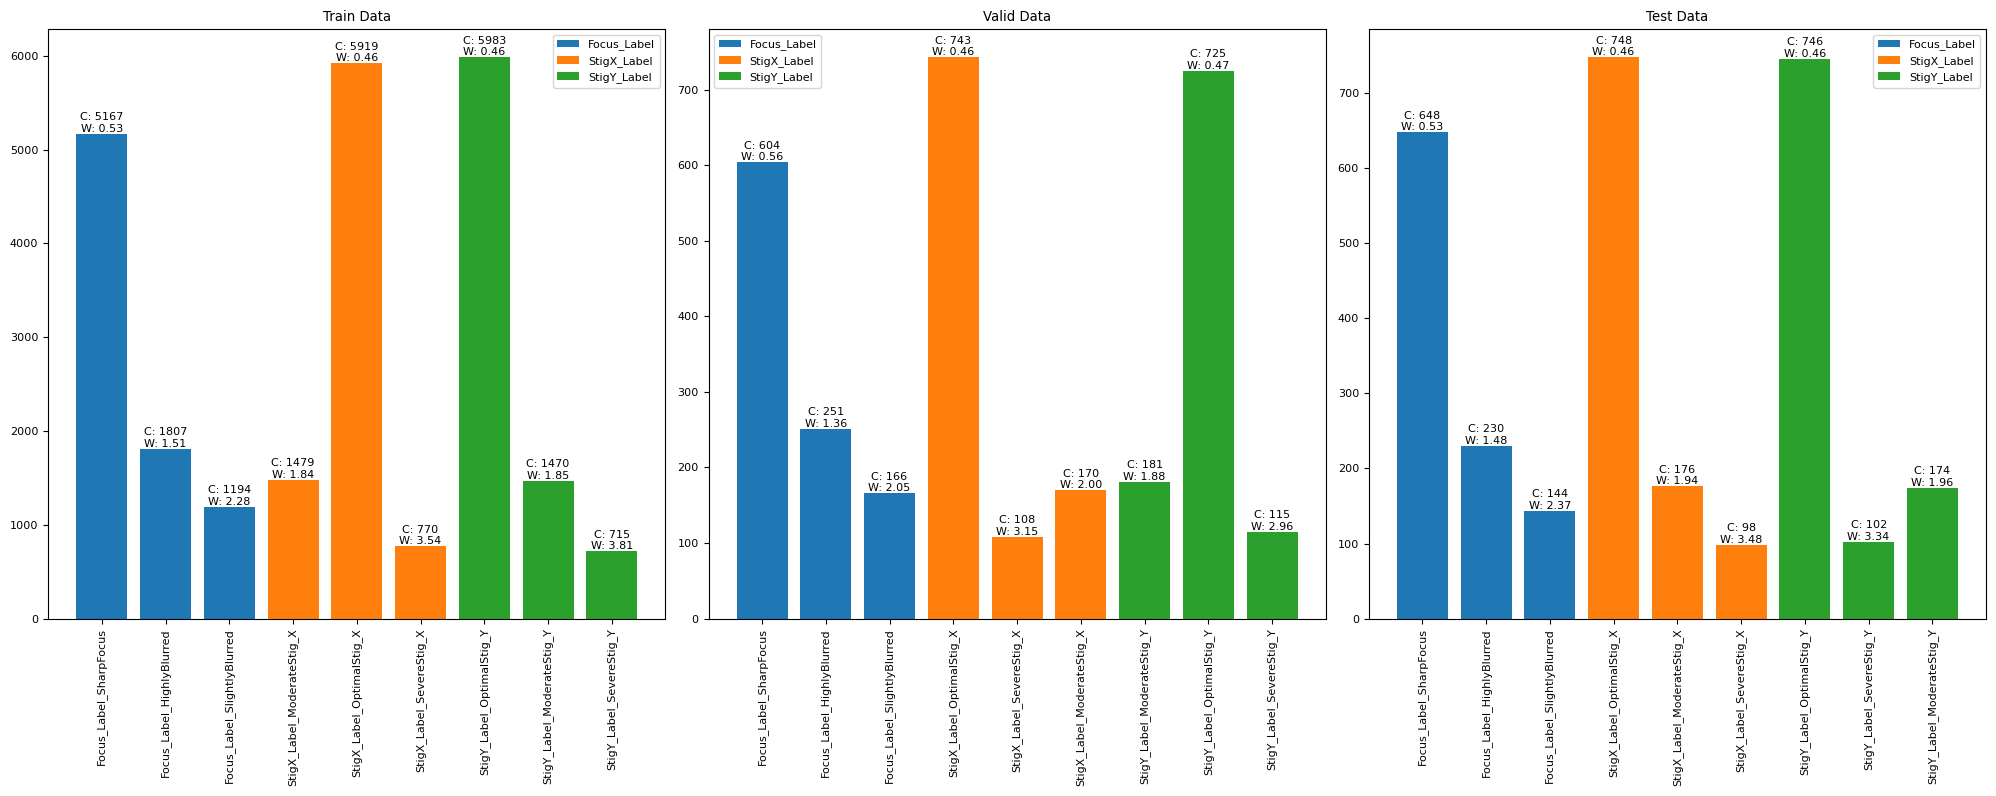

In [118]:
def add_annotations(ax, bars, sub_df):
    for bar, (_, row) in zip(bars, sub_df.iterrows()):
        x = bar.get_x() + bar.get_width() / 2.0
        y = bar.get_height()
        ax.annotate(f"C: {int(row['Count'])}\nW: {row['Weight']:.2f}", 
                    (x, y), 
                    ha='center', 
                    va='bottom', 
                    fontsize=8)

def plot_single_split(ax, df, split, problem_type):
    filtered_df = df.loc[split]
    x_ticks = []
    
    labels = filtered_df.index.get_level_values('label').unique()
    for label in labels:
        sub_df = filtered_df.loc[label]
        bars = ax.bar(sub_df.index, sub_df['Count'], label=f"{label}")
        add_annotations(ax, bars, sub_df)
        
        x_ticks.extend([f"{label}_{cls}" for cls in sub_df.index])
    
    ax.legend()
    ax.set_xticklabels(x_ticks, rotation=90, fontsize=8)
    ax.set_title(f"{split.capitalize()} Data")

def plot_dataset_info(df, config):
    problem_type = config['Experiment']['PROBLEM_TYPE']
    splits = ['train', 'valid', 'test']
    
    fig, axs = plt.subplots(1, len(splits), figsize=(20, 8))
    
    for i, split in enumerate(splits):
        plot_single_split(axs[i], df, split, problem_type)
        
    plt.tight_layout()
    plt.show()

# Example usage
plot_dataset_info(info, config)


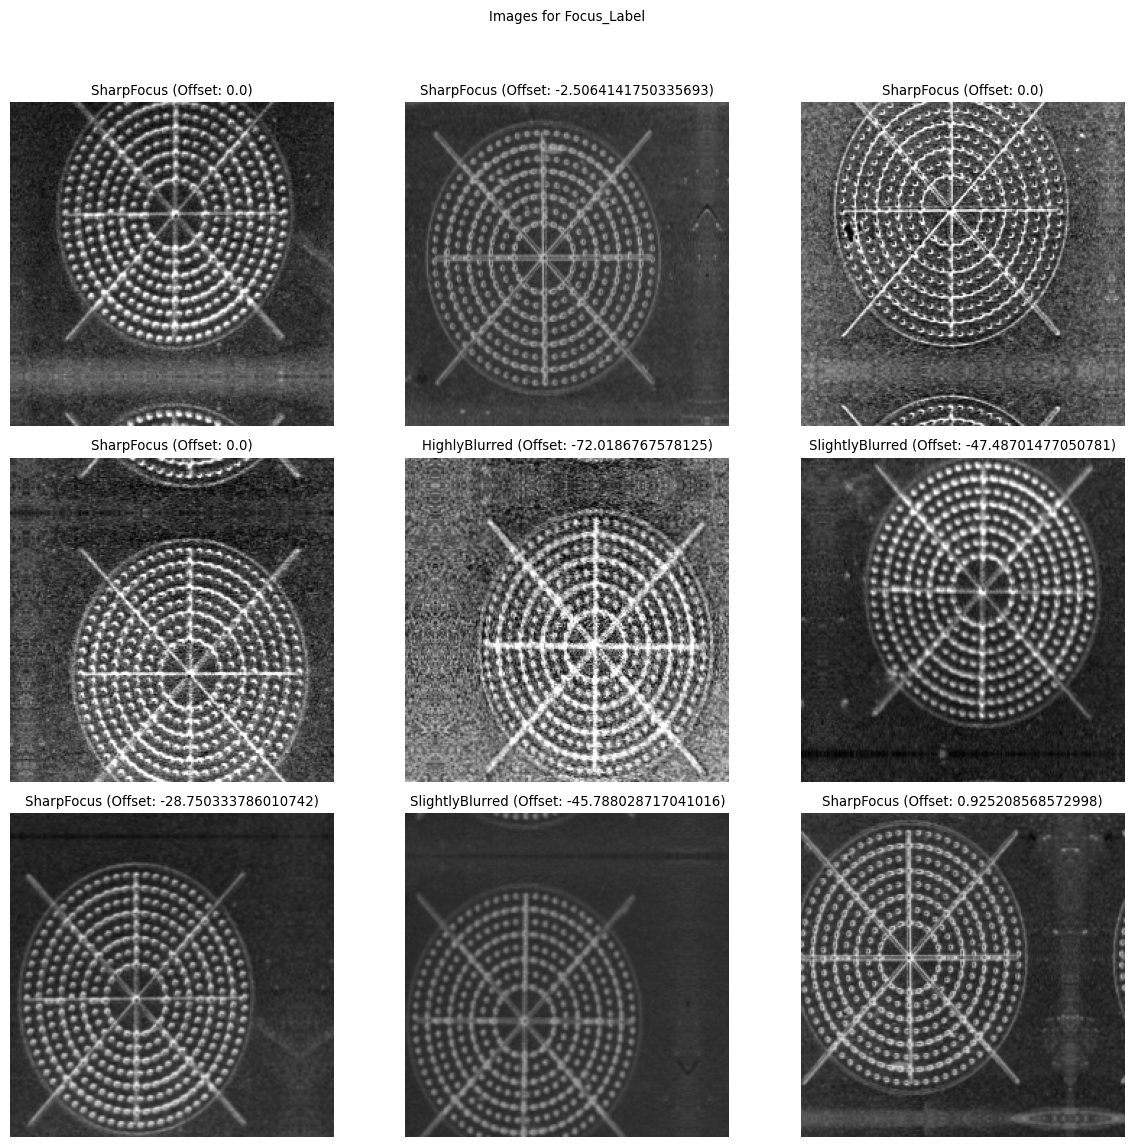

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [119]:
import textwrap

# Assume label_encoders and config are available
label_keys = ['Focus_Label', 'StigX_Label', 'StigY_Label']
problem_type = config['Experiment']['PROBLEM_TYPE']

plt.rcParams.update({'font.size': 8})  # Reduce font size
fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # Enlarge figure size

if problem_type in ['Multi-Class', 'Binary']:
    for label_key in label_keys:
        label_encoder = label_encoders.get(label_key, None)
        fig.suptitle(f"Images for {label_key}")

        # Take one batch from the training dataset
        for data in datasets['train'][label_key].take(1):
            images, labels = data[:2]
            offsets = data[2] if len(data) > 2 else None  # Include offsets if they exist

            # Loop over the batch to plot images, labels, and offsets
            for i in range(min(len(images), 9)):  # Show up to 9 images
                ax = axes[i // 3, i % 3]
                ax.imshow(images[i].numpy())

                label_value = labels[i].numpy()
                offset_value = offsets[i].numpy() if offsets is not None else "N/A"

                # Use label encoder to get original label name if available
                if label_encoder:
                    label_name = label_encoder.inverse_transform([label_value])[0]
                else:
                    label_name = label_value

                ax.set_title(f"{label_name} (Offset: {offset_value})")
                ax.axis("off")

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

elif problem_type == 'Multi-Output':
    fig.suptitle("Images for Multi-Output")

    # Take one batch from the training dataset
    for data in datasets['train']['Multi_Output'].take(1):
        images, labels = data[:2]
        offsets = data[2] if len(data) > 2 else None  # Include offsets if they exist

        # Loop over the batch to plot images, labels, and offsets
        for i in range(min(len(images), 9)):  # Show up to 9 images
            ax = axes[i // 3, i % 3]
            ax.imshow(images[i].numpy())

            label_values = labels[i].numpy()
            offset_values = offsets[i].numpy() if offsets is not None else ["N/A"] * len(label_keys)
            # Round offset values to 2 decimal places
            offset_values = [f"{offset:.2f}" for offset in offset_values]

            label_names = []
            for label_value, label_key in zip(label_values, label_keys):
                label_encoder = label_encoders.get(label_key, None)
                if label_encoder:
                    label_names.append(label_encoder.inverse_transform([label_value])[0])
                else:
                    label_names.append(str(label_value))

            title_text = ", ".join(f"{name} ({offset})" for name, offset in zip(label_names, offset_values))
            ax.set_title("\n".join(textwrap.wrap(title_text, 30)))  # Wrap text to limit the width
            ax.axis("off")

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
else:
    print("Unknown problem type specified in config. Please check.")


## Defining the Models

In [120]:
# Transfer learning models
def create_transfer_model(base_model, input_shape: tuple, num_classes: int, hidden_units: list, dropout_rate: float, regularizer_rate: float) -> keras.Model:
    """Creates a transfer learning model based on a given base model."""
    base_model.trainable = False

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D()
    ])

    for units in hidden_units:
        model.add(layers.Dense(units, kernel_regularizer=keras.regularizers.l2(regularizer_rate), bias_regularizer=keras.regularizers.l2(regularizer_rate)))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(dropout_rate))
        
    activation, units = determine_activation_and_units(num_classes)
    model.add(layers.Dense(units, activation=activation))

    return model

def create_mobilenetv2_transfer_model(input_shape: tuple, num_classes: int) -> keras.Model:
    """Creates a MobileNetV2 based transfer learning model."""
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    return create_transfer_model(base_model, input_shape, num_classes, [128, 64], 0.5, 0.001)

def create_inceptionv3_transfer_model(input_shape: tuple, num_classes: int) -> keras.Model:
    """Creates an InceptionV3 based transfer learning model."""
    base_model = tf.keras.applications.InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet')
    return create_transfer_model(base_model, input_shape, num_classes, [128, 64], 0.5, 0.001)

def create_resnet50_transfer_model(input_shape: tuple, num_classes: int) -> keras.Model:
    """Creates a ResNet50 based transfer learning model."""
    base_model = tf.keras.applications.ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
    return create_transfer_model(base_model, input_shape, num_classes, [256, 128], 0.5, 0.001)

# Define the function to create a basic CNN model
def create_basic_cnn_model(input_shape, num_classes):
    conv2d_filter_size = (3, 3)
    conv2d_activation = 'relu'
    dense_activation = 'relu'
    num_conv_blocks = 3

    model = tf.keras.models.Sequential()

    # Explicitly define the input shape
    model.add(tf.keras.layers.Input(shape=input_shape))

    for _ in range(num_conv_blocks):
        model.add(tf.keras.layers.Conv2D(32 * (2**_), conv2d_filter_size, activation=conv2d_activation, padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))

    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(128, activation=dense_activation))

    activation, units = determine_activation_and_units(num_classes)
    model.add(layers.Dense(units, activation=activation))

    return model

# Define the function to create a small version of the Xception network
def create_small_xception_model(input_shape, num_classes):
    # Input layer
    inputs = keras.Input(shape=input_shape)

    # Entry block: Initial Convolution and BatchNormalization
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    previous_block_activation = x  # Set aside residual for later use

    # Middle flow: Stacking Separable Convolution blocks
    for size in [256, 512, 728]:
        # ReLU activation
        x = layers.Activation("relu")(x)
        # Separable Convolution
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        # ReLU activation
        x = layers.Activation("relu")(x)
        # Separable Convolution
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        # Max Pooling
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual from previous block and add it to the current block
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Exit flow: Final Separable Convolution, BatchNormalization, and Global Average Pooling
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)

    activation, units = determine_activation_and_units(num_classes)

    # Dropout and Dense output layer
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)

    return keras.Model(inputs, outputs)

# Model Selection function to select which model to use
def select_model(model_name: str, input_shape: tuple, num_classes: int) -> keras.Model:
    """Selects a model to use based on the given model name."""
    model_map = {
        "mobilenetv2": create_mobilenetv2_transfer_model,
        "inceptionv3": create_inceptionv3_transfer_model,
        "resnet50": create_resnet50_transfer_model,
        "small_xception": create_small_xception_model,
        "basic_cnn": create_basic_cnn_model
    }
    if model_name not in model_map:
        raise ValueError("Invalid model name")

    return model_map[model_name](input_shape, num_classes)

def determine_activation_and_units(num_classes: int) -> tuple:
    """Determine the activation function and units based on the number of classes and problem type from config."""
    problem_type = config.get('Experiment').get('PROBLEM_TYPE')
    if problem_type == 'Multi-Label':
        return "sigmoid", num_classes
    elif problem_type == 'Binary' or num_classes == 2:
        return "sigmoid", 1
    elif problem_type == 'Multi-Class':
        return "softmax", num_classes
    elif problem_type == 'Multi-Output':
        # For multi-output, we can treat each output independently.
        # Here we assume each output is a multi-class problem.
        return "softmax", num_classes
    else:
        raise ValueError(f"Invalid problem_type: {problem_type}")

    

In [121]:
from tensorflow.keras import callbacks

# Model Configuration
config['Model']['EPOCHS'] = 100
config['Model']['LEARNING_RATE'] = 1e-3
config['Model']['EARLY_STOPPING_PATIENCE'] = 5
config['Model']['REDUCE_LR_PATIENCE'] = 3
config['Model']['MIN_LR'] = 1e-6
config['Model']['LOSS'] = "binary_crossentropy"

# Recommended metrics based on problem type
recommended_metrics = {
    'Binary': ['accuracy', 'precision', 'recall', 'AUC'],
    'Multi-Class': ['accuracy', 'categorical_crossentropy'],
    'Multi-Output': ['accuracy', 'categorical_crossentropy'], 
    'Multi-Label': ['accuracy', 'precision', 'recall']
}

# Function to compile and initialize models
def compile_and_initialize_models():
    compiled_models = {}
    input_shape = (config['Model']['IMG_SIZE'], config['Model']['IMG_SIZE'], 3)
    num_classes = 3  # Assuming 3 classes for each label based on the config

    problem_type = config['Experiment']['PROBLEM_TYPE']

    print(f"Starting model compilation and initialization for {problem_type} problem...")

    # Create the base directory for the experiment
    experiment_name = f"{config['Experiment']['NAME']} - {problem_type}"
    base_dir = f"./{experiment_name}"
    os.makedirs(base_dir, exist_ok=True)
    print(f"Created base directory for the experiment: {base_dir}")

    # Callbacks common to all models
    print("Setting up common callbacks...")
    early_stopping = callbacks.EarlyStopping(patience=config['Model']['EARLY_STOPPING_PATIENCE'], restore_best_weights=True)
    reduce_lr = callbacks.ReduceLROnPlateau(patience=config['Model']['REDUCE_LR_PATIENCE'], min_lr=config['Model']['MIN_LR'])
    print("Common callbacks set up successfully.")

    label_names = config['Labels']['MAPPINGS'].keys() if problem_type == 'Multi-Class' else ['']

    for label_name in label_names:
        label_dir = os.path.join(base_dir, label_name)
        os.makedirs(label_dir, exist_ok=True)

        for model_name in ['mobilenetv2', 'inceptionv3', 'resnet50', 'small_xception', 'basic_cnn']:
            print(f"Processing model: {model_name}")

            # Directory to save models of this type
            model_dir = os.path.join(label_dir, model_name)
            os.makedirs(model_dir, exist_ok=True)
            print(f"Created directory for {model_name}: {model_dir}")
            
            # ModelCheckpoint and TensorBoard callbacks
            datetime_str = datetime.now().strftime("%Y%m%d-%I%M%S%p")
            checkpoint_path = os.path.join(model_dir, f"saved_model_{datetime_str}_epoch_{{epoch}}_val_loss_{{val_loss:.2f}}_val_acc_{{val_accuracy:.2f}}.h5")
            model_checkpoint = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True)
            tensorboard_log_dir = os.path.join(model_dir, "logs", datetime_str)
            tensorboard = callbacks.TensorBoard(log_dir=tensorboard_log_dir)

            # Combine all callbacks
            all_callbacks = [early_stopping, reduce_lr, model_checkpoint, tensorboard]
            print(f"Callbacks for {model_name} set up successfully.")
            
            # Model Initialization and Compilation
            model = select_model(model_name, input_shape, num_classes)
            metrics_to_use = recommended_metrics.get(problem_type, ['accuracy'])  # Default to 'accuracy' if problem type is not recognized
            model.compile(optimizer='adam', loss=config['Model']['LOSS'], metrics=metrics_to_use)
            print(f"{model_name} compiled successfully.")
            
            # Save the model and callbacks
            compiled_models[model_name] = {'model': model, 'callbacks': all_callbacks}
            print(f"{model_name} saved successfully.\n")

    print("Model compilation and initialization completed.")
    return compiled_models


# Compile and initialize models
compiled_models = compile_and_initialize_models()
print("Models compiled and initialized successfully.")

Starting model compilation and initialization for Multi-Class problem...
Created base directory for the experiment: ./Version8 - Multi-Class
Setting up common callbacks...
Common callbacks set up successfully.
Processing model: mobilenetv2
Created directory for mobilenetv2: ./Version8 - Multi-Class\Focus_Label\mobilenetv2
Callbacks for mobilenetv2 set up successfully.
mobilenetv2 compiled successfully.
mobilenetv2 saved successfully.

Processing model: inceptionv3
Created directory for inceptionv3: ./Version8 - Multi-Class\Focus_Label\inceptionv3
Callbacks for inceptionv3 set up successfully.
inceptionv3 compiled successfully.
inceptionv3 saved successfully.

Processing model: resnet50
Created directory for resnet50: ./Version8 - Multi-Class\Focus_Label\resnet50
Callbacks for resnet50 set up successfully.
resnet50 compiled successfully.
resnet50 saved successfully.

Processing model: small_xception
Created directory for small_xception: ./Version8 - Multi-Class\Focus_Label\small_xceptio

## Train the Models

In [122]:
import os
from datetime import datetime
from tensorflow import keras
from tensorflow.keras import callbacks
import pandas as pd

def save_metrics_to_csv(history, csv_path):
    """
    Save the training and validation metrics from a training history to a CSV file.

    Parameters:
    - history: History object from model training
    - csv_path: The path where the CSV file should be saved
    """
    # Convert the history.history dict to a Pandas DataFrame
    df_history = pd.DataFrame(history.history)
    
    # Save it to CSV
    df_history.to_csv(csv_path, index=False)
    print(f"Saved metrics to {csv_path}")
    
def train_multi_class(label, train_dataset, valid_dataset, compiled_models, config, info):
    """
    Train models for the multi-class problem for a given label.
    """
    train_data = train_dataset[label]
    valid_data = valid_dataset[label]
    
    # Fetch class weights if needed
    class_weights = None
    if config.get('USE_CLASS_WEIGHTS', False):
        # Convert class names to indices
        class_mappings = config['Labels']['MAPPINGS'][label]
        class_weights = {class_mappings[name]: weight for name, weight in info.loc['train', label]['Weight'].items()}
    
    for model_name, model_info in compiled_models.items():
        model = model_info['model']
        callbacks = model_info['callbacks']
        
        print(f"Training {model_name} for label {label}...")
        history = model.fit(
            train_data,
            validation_data=valid_data,
            epochs=config['Model']['EPOCHS'],
            class_weight=class_weights,
            callbacks=callbacks
        )
        # Save metrics
        csv_path = os.path.join("./", config['Experiment']['NAME'], f"{label}_{model_name}_metrics.csv")
        save_metrics_to_csv(history, csv_path)

def train_multi_output(train_dataset, valid_dataset, compiled_models, config, info):
    """
    Train models for the multi-output problem.
    """
    train_data = train_dataset['Multi_Output']
    valid_data = valid_dataset['Multi_Output']
    
    # Fetch class weights if needed
    class_weights = None
    if config.get('USE_CLASS_WEIGHTS', False):
        class_weights = get_class_weights(train_data, info, label)
        # Combine weights from all labels in multi-output problem (you might need a more sophisticated handling)
        # class_weights = {}
        # for label in config['Labels']['MAPPINGS'].keys():
        #     class_weights.update(info.loc['train', label]['Weight'].to_dict())
        

    for model_name, model_info in compiled_models.items():
        model = model_info['model']
        callbacks = model_info['callbacks']
        
        print(f"Training {model_name} for multi-output...")
        history = model.fit(
            train_data,
            validation_data=valid_data,
            epochs=config['Model']['EPOCHS'],
            class_weight=class_weights,
            callbacks=callbacks
        )
        # Save metrics
        csv_path = os.path.join("./", config['Experiment']['NAME'], f"multi_output_{model_name}_metrics.csv")
        save_metrics_to_csv(history, csv_path)
        
def get_class_weights(data, info, label):
    """
    Compute class weights based on training data distribution.
    """
    class_counts = info.loc['train', label]['Count'].to_dict()
    num_classes = len(class_counts)
    class_labels = list(range(num_classes))
    class_weights = compute_class_weight('balanced', class_labels, data[1])
    return dict(zip(class_labels, class_weights))

# Define the function for training
def train_models(datasets, info, config, compiled_models):
    """
    Trains models for multi-output or multi-class problems.
    
    Parameters:
    - datasets: Dictionary containing the training, validation, and test datasets
    - info: DataFrame containing information about class weights
    - config: Configuration dictionary
    """
    # Detect the problem type from the configuration
    problem_type = config['Experiment']['PROBLEM_TYPE']
    print(f"Detected problem type: {problem_type}")

    # Determine which datasets to use based on the problem type
    train_dataset = datasets['train']
    valid_dataset = datasets['valid']
    test_dataset = datasets['test']

    # Initialize a CSV file to save training and validation metrics
    metrics_csv_path = os.path.join("./", config['Experiment']['NAME'], "metrics.csv")
    metrics_df = pd.DataFrame()

    # Initialize loops based on the problem type
    if problem_type == 'Multi-Class':
        labels = config['Labels']['MAPPINGS'].keys()
        for label in labels:
            print(f"Training models for label: {label}")
            train_multi_class(label, train_dataset, valid_dataset, compiled_models, config, info)
            
    elif problem_type == 'Multi-Output':
        print("Training models for multi-output problem")
        train_multi_output(train_dataset, valid_dataset, compiled_models, config, info)
    
    else:
        print("Invalid problem type specified. Exiting.")
        return

    print("Training completed.")

# Additions to the config
config['USE_CLASS_WEIGHTS'] = False  # Decide whether to use class weights or not

# Calling the function to train the models
train_models(datasets, info, config, compiled_models)


Detected problem type: Multi-Class
Training models for label: Focus_Label
Training mobilenetv2 for label Focus_Label...


Epoch 1/100


ValueError: in user code:

    File "c:\Users\aaron.woods\AppData\Local\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\aaron.woods\AppData\Local\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\aaron.woods\AppData\Local\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\aaron.woods\AppData\Local\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1085, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "c:\Users\aaron.woods\AppData\Local\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1179, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "c:\Users\aaron.woods\AppData\Local\anaconda3\lib\site-packages\keras\src\engine\compile_utils.py", line 577, in update_state
        self.build(y_pred, y_true)
    File "c:\Users\aaron.woods\AppData\Local\anaconda3\lib\site-packages\keras\src\engine\compile_utils.py", line 483, in build
        self._metrics = tf.__internal__.nest.map_structure_up_to(
    File "c:\Users\aaron.woods\AppData\Local\anaconda3\lib\site-packages\keras\src\engine\compile_utils.py", line 631, in _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "c:\Users\aaron.woods\AppData\Local\anaconda3\lib\site-packages\keras\src\engine\compile_utils.py", line 631, in <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "c:\Users\aaron.woods\AppData\Local\anaconda3\lib\site-packages\keras\src\engine\compile_utils.py", line 652, in _get_metric_object
        y_t_rank = len(y_t.shape.as_list())

    ValueError: as_list() is not defined on an unknown TensorShape.


In [ ]:





def get_latest_checkpoint(model_dirs: List[str]) -> Optional[str]:
    """
    Return the latest checkpoint file from the given model directories.
    
    Parameters:
    - model_dirs (List[str]): A list of directories where the model checkpoint files are stored.
    
    Returns:
    - Optional[str]: The path of the latest checkpoint file, or None if no checkpoint files are found.
    """
    for model_dir in model_dirs:
        checkpoint_pattern = os.path.join(model_dir, '*.h5')
        list_of_files = glob.glob(checkpoint_pattern)
        
        if not list_of_files:
            print(f"No checkpoint files found in {model_dir}.")
            continue  # Skip to the next directory
        
        latest_checkpoint = max(list_of_files, key=os.path.getctime)
        print(f"Found {len(list_of_files)} checkpoint files in {model_dir}.")
        print(f"Resuming from the latest checkpoint: {latest_checkpoint}.")
        
        return latest_checkpoint
    
    print("No checkpoints found in any of the specified directories.")
    return None

def load_or_adapt_model(initialized_model, latest_checkpoint, expected_output_units):
    try:
        # Try to load the full model
        model = load_model(latest_checkpoint)
        last_layer_units = model.layers[-1].units
        if last_layer_units == expected_output_units:
            return model, True
        # Remove last layer and add a new one
        new_output = layers.Dense(expected_output_units, activation='softmax')(model.layers[-2].output)
        model = Model(inputs=model.inputs, outputs=new_output)
        return model, False
    except Exception as e:
        print(f"Exception: {e}")
        print("Could not load the full model. Using initialized model and loading its weights.")

        # Create a new model based on the initialized_model but with expected_output_units
        new_output = layers.Dense(expected_output_units, activation='softmax')(initialized_model.layers[-2].output)
        initialized_model = Model(inputs=initialized_model.inputs, outputs=new_output)

        # Try to load the weights
        binary_model = load_model(latest_checkpoint)
        binary_model = Model(inputs=binary_model.inputs, outputs=binary_model.layers[-2].output)

        initialized_model.set_weights(binary_model.get_weights())
        return initialized_model, False


def load_checkpoint_and_results(model, model_dirs):
    latest_checkpoint = get_latest_checkpoint(model_dirs)
    if latest_checkpoint:
        # Load the checkpoint and results
        return latest_checkpoint, load_results(latest_checkpoint)
    return None, None





In [ ]:

# ------------------ Model Utilities ------------------

def get_latest_checkpoint(model_dirs: List[str]) -> Optional[str]:
    """Return the latest checkpoint file from given model directories."""
    for model_dir in model_dirs:
        list_of_files = glob.glob(os.path.join(model_dir, '*.h5'))
        
        if not list_of_files:
            print(f"No checkpoint files found in {model_dir}.")
            continue
        
        latest_checkpoint = max(list_of_files, key=os.path.getctime)
        print(f"Found {len(list_of_files)} checkpoint files in {model_dir}.")
        print(f"Resuming from the latest checkpoint: {latest_checkpoint}.")
        return latest_checkpoint
    
    print("No checkpoints found in any of the specified directories.")
    return None

def train_and_evaluate_single_model(model: Model, model_name: str, label_column: str, 
                                    train_ds: Any, valid_ds: Any, config: Dict[str, Any], 
                                    callbacks: Any, initial_epoch: int = 0) -> Tuple[Dict[str, Any], Dict[str, Any]]:
    train_weights_dict = {config['Labels']['MAPPINGS'][label_column][key]: value['Weight'] for key, value in train_weights.items()}
    train_cb_key, valid_cb_key, _ = update_callback_keys(label_column, model_name)
    history = train_model(model, train_ds, valid_ds, config, train_weights_dict, callbacks[train_cb_key], initial_epoch=initial_epoch)
    return process_history(history, 'training'), process_history(history, 'validation')


# ------------------ Main Training Loop ------------------

def train_and_evaluate_all_models(model_names: List[str], label_columns: List[str], datasets: Dict[str, Any], 
                                  models: Dict[str, Model], config: Dict[str, Any], 
                                  callbacks: Any, results: Optional[Dict[str, Any]] = None):
    problem_type = config['Experiment'].get('PROBLEM_TYPE', 'Multi-Class')
    
    if results is None:
        results = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(dict))))
    
    for label_column in label_columns:
        # train_weights = None
        
        for model_name in model_names:
            model = models.get(model_name, None)
            if model is None:
                continue
            
            train_ds, valid_ds, test_ds = (datasets[ds_type][label_column] for ds_type in ['train', 'valid', 'test'])
            train_ds, valid_ds, test_ds = (convert_labels(ds, problem_type) for ds in [train_ds, valid_ds, test_ds])
            
            # Remove offset value labels from the datasets
            # TypeError: outer_factory.<locals>.inner_factory.<locals>.<lambda>() takes 2 positional arguments but 3 were given
            
            train_ds, valid_ds, test_ds = (ds.map(lambda x, y, z: (x, y)) for ds in [train_ds, valid_ds, test_ds])
            
            base_model_dir = os.path.join(BASE_DIR, MODELS_DIR_NAME)
            model_dirs = [
                os.path.join(base_model_dir, exp_name, f"{label_column}_models", f"{model_name}_models")
                for exp_name in ["default_experiment", "binary_classification_v1"]
            ]
            
            latest_checkpoint, prev_results = load_checkpoint_and_results(model, model_dirs)
            
            if latest_checkpoint:
                model = load_or_adapt_model(model, latest_checkpoint, expected_output_units=3)
                if prev_results:
                    results = prev_results
            
            train_results, valid_results = train_and_evaluate_single_model(
                model, model_name, label_column, train_ds, valid_ds, config, callbacks
            )
            results[model_name][label_column]['training'] = train_results
            results[model_name][label_column]['validation'] = valid_results
            
            evaluation_results = evaluate_model(model, test_ds, config)
            print(f'{model_name} on train - Test Loss: {evaluation_results[0]:.4f}, Test Accuracy: {evaluation_results[1]*100:.2f}%')
            
    save_results_to_pickle(results)

# Execute the main loop
results = None  # Or initialize with some existing data if available.
model_names = ["mobilenetv2", "small_xception", "basic_cnn", "inceptionv3", "resnet50"]
label_columns = ["Focus_Label", "StigX_Label", "StigY_Label"]
train_and_evaluate_all_models(model_names, label_columns, datasets, models, config, callbacks, results=results)
